In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation


### Практический пример с соревнования X5 

http://retailhero.ai/#rec141268104

Импортируем нужные библиотеки и предобработаем данные:

In [2]:
# !pip install scikit-uplift==0.2.0

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [3]:
# Чтение данных
df = pd.read_csv('data.csv')#, index_col='client_id')

df1 = df.copy()

In [4]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Как мы видим, в данных нет пропусков, т.е. их обрабатывать не нужно

### Обзор данных


##### Обзор целевой переменной

In [6]:
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

#### Обзор количественных признаков

In [7]:
NUM_FEATURE_NAMES = ['recency','history','used_discount',\
                    'used_bogo','is_referral']

#### Обзор номинативных признаков

In [8]:
df.select_dtypes(include='object').columns

Index(['zip_code', 'channel', 'offer'], dtype='object')

In [9]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

zip_code

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
****************************************************************************************************

channel

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
****************************************************************************************************

offer

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64
****************************************************************************************************



In [10]:
df.rename(columns ={'conversion':'target', 'offer':'treatment'}, inplace=True)

In [11]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [12]:
df.loc[df['treatment'] == 'Buy One Get One', 'treatment']=1
df.loc[df['treatment'] == 'Discount', 'treatment']=1
df.loc[df['treatment'] == 'No Offer', 'treatment']=0

In [13]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [14]:
models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%':[],
    'uplift@10%':[]
}

In [15]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

In [16]:
treat_train = X_train['treatment']
X_train= X_train.drop(columns=['treatment'], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48000 entries, 1098 to 2732
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        48000 non-null  int64  
 1   history        48000 non-null  float64
 2   used_discount  48000 non-null  int64  
 3   used_bogo      48000 non-null  int64  
 4   zip_code       48000 non-null  object 
 5   is_referral    48000 non-null  int64  
 6   channel        48000 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ MB


In [17]:
X_train['zip_code'].value_counts()

Surburban    21599
Urban        19218
Rural         7183
Name: zip_code, dtype: int64

In [18]:
X_train['channel'].value_counts()

Web             21122
Phone           21045
Multichannel     5833
Name: channel, dtype: int64

In [19]:
cat_features = ['zip_code']#,'channel']

In [20]:
treat_train

1098     1
13764    1
45116    1
15363    0
44498    0
        ..
45891    0
52416    1
42613    1
43567    1
2732     1
Name: treatment, Length: 48000, dtype: object

In [21]:
y_train

1098     0
13764    0
45116    0
15363    0
44498    0
        ..
45891    0
52416    1
42613    1
43567    0
2732     0
Name: target, Length: 48000, dtype: int64

In [22]:
treat_test = X_test['treatment']
X_test= X_test.drop(columns=['treatment'], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 11277 to 26707
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        16000 non-null  int64  
 1   history        16000 non-null  float64
 2   used_discount  16000 non-null  int64  
 3   used_bogo      16000 non-null  int64  
 4   zip_code       16000 non-null  object 
 5   is_referral    16000 non-null  int64  
 6   channel        16000 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 1000.0+ KB


Как показало исследование влияния признаков на пробную модель, самой меньшей важностью обладают признаки "channel", "history", "regency". Попробуем их удалить из модели и еще раз обучить модель.

In [23]:
X_test= X_test.drop(columns=['history', 'channel', 'recency'], axis=1)

In [24]:
X_train= X_train.drop(columns=['history', 'channel', 'recency'], axis=1)

uplift@30%: 0.0646
uplift@20%: 0.0717
uplift@10%: 0.0819


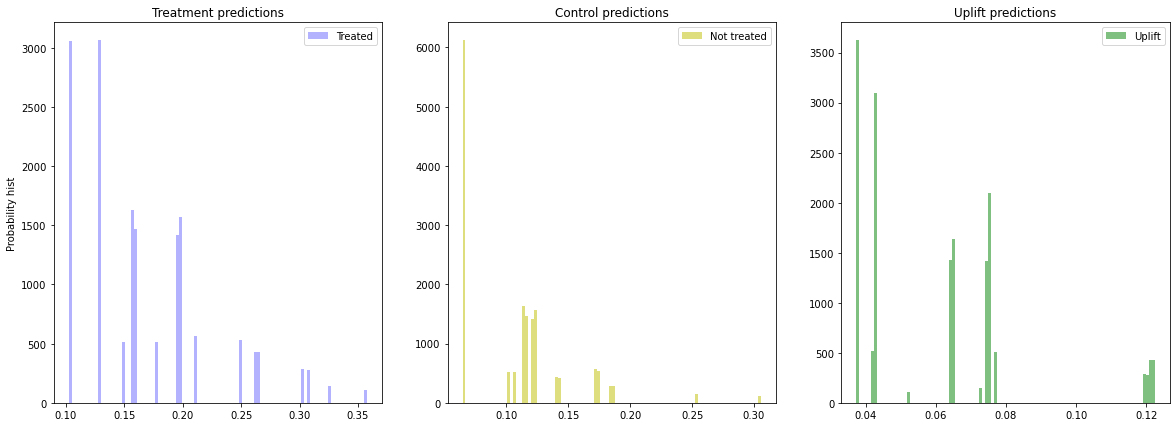

In [25]:
sm1 = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm1 = sm1.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm1 = sm1.predict(X_test)

sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm1, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score_30:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_30)

sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm1, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['uplift@20%'].append(sm_score_20)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm1, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')

models_results['uplift@10%'].append(sm_score_10)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm1.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm1.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Эксперимент показал повышение метрик uplift@

In [26]:
sm_fi = pd.DataFrame({
    'feature_name': sm1.estimator.feature_names_,
    'feature_score': sm1.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,used_bogo,25.176455
1,treatment,23.655311
2,is_referral,19.473537
3,used_discount,17.520841
4,zip_code,14.173856


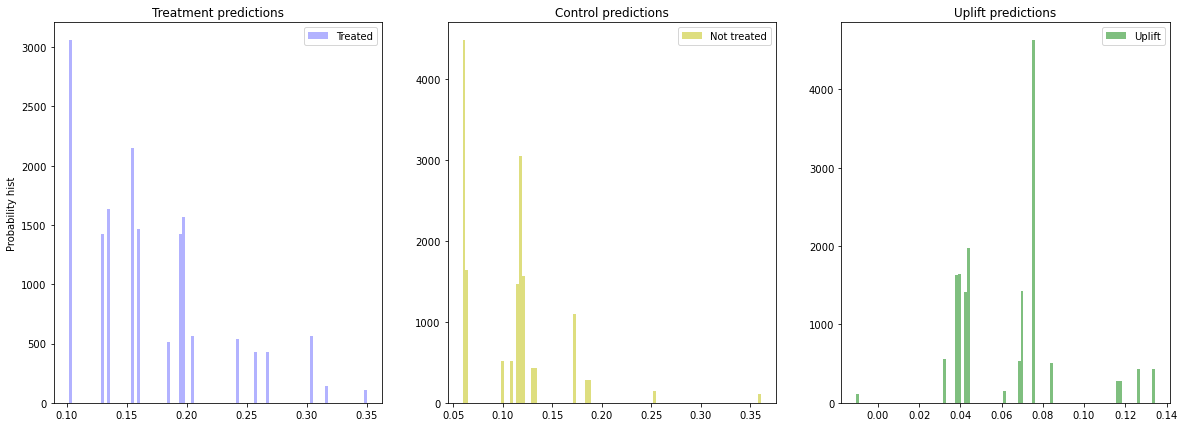

In [27]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, \
                          strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score_30)

tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, \
                          strategy='by_group', k=0.2)

models_results['uplift@20%'].append(tm_score_20)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, \
                          strategy='by_group', k=0.1)

models_results['uplift@10%'].append(tm_score_10)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [28]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, \
                       treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_30)

ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, \
                       treatment=treat_test, strategy='by_group', k=0.2)

models_results['uplift@20%'].append(ct_score_20)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, \
                       treatment=treat_test, strategy='by_group', k=0.1)

models_results['uplift@10%'].append(ct_score_10)

<ipython-input-28-aeecd10b78ad>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


In [29]:
print(pd.DataFrame(models_results))


              approach  uplift@30%  uplift@20%  uplift@10%
0            SoloModel    0.064597    0.071715    0.081859
1            TwoModels    0.064252    0.068942    0.081859
2  ClassTransformation    0.069537    0.070535    0.085381


Можно наблюдать, что ClassTransformation дает самые высокие показатели.

Вариант с деревом решений

In [30]:
!git clone https://github.com/ub8er/causalml.git
%cd causalml
!pip install -r requirements.txt
!python setup.py build_ext --inplace
!python setup.py install

fatal: destination path 'causalml' already exists and is not an empty directory.
/Users/maria/Documents/GeekBrains/ML  в бизнесе/урок 4/lection4_materials/causalml
  Using cached numpy-1.18.5-cp38-cp38-macosx_10_9_x86_64.whl (15.1 MB)
  Using cached scipy-1.4.1-cp38-cp38-macosx_10_9_x86_64.whl (28.8 MB)
  Using cached scikit_learn-0.23.2-cp38-cp38-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached xgboost-1.5.1.tar.gz (730 kB)
  Using cached slicer-0.0.3-py3-none-any.whl (11 kB)
  Using cached progressbar2-4.0.0-py2.py3-none-any.whl (26 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.43.0-cp38-cp38-macosx_10_10_x86_64.whl (4.2 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached libclang-12.0

In [32]:
df1.rename(columns ={'conversion':'target', 'offer':'treatment'}, inplace=True)

In [33]:
df1['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [34]:
df1.loc[df['treatment'] == 'Buy One Get One', 'treatment']=1
df1.loc[df['treatment'] == 'Discount', 'treatment']=1
df1.loc[df['treatment'] == 'No Offer', 'treatment']=0

In [35]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), 
                                                    df['target'], random_state=0)

In [36]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'),\
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In [37]:
X_train_tree

,recency,history,used_discount,used_bogo,is_referral,channel,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
1098,8,63.58,1,0,1,Phone,1,0,1,0,0,1,0
13764,3,395.35,1,0,1,Web,1,0,1,0,0,0,1
45116,4,1307.99,1,1,1,Phone,1,1,0,0,0,1,0
15363,10,159.01,0,1,1,Web,0,0,1,0,0,0,1
44498,1,276.00,1,0,0,Phone,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,9,34.26,1,0,0,Phone,0,0,0,1,0,1,0
52416,5,264.71,1,1,0,Multichannel,1,0,0,1,1,0,0
42613,12,419.44,0,1,1,Multichannel,1,0,0,1,1,0,0
43567,1,331.56,0,1,0,Multichannel,1,0,0,1,1,0,0


#### Поставить causalml так и не получилось

In [38]:
%%time
from IPython.display import Image
from  causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
#from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

#graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
#Image(graph.create_png())
tree.plot_tree(uplift_model.fitted_uplift_tree)

ModuleNotFoundError: No module named 'slicer'

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html